In [1]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
# get utils for thresholds
from src import util_analysis 
from src import util_process_prolific as util_process
import importlib
from tqdm.auto import tqdm
import multiprocessing as mp
from scipy import stats 

### Run stats on human results 
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# So that we can edit the text in illustrator
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
fig_out_dir = Path("final_figures/figure_4")
fig_out_dir.mkdir(exist_ok=True, parents=True)


# Load pre-computed human threshold data

In [8]:
path_to_human_results = Path('final_results_dir')
human_thresh_df = pd.read_pickle(path_to_human_results / 'summary_2024_human_threshold_results_avg_sex_cond_rel_part_max.pdpkl')
N = 33

human_thresh_df_summary = human_thresh_df.groupby(['elev_delta', 'azim_delta']).agg({'threshold':['mean', 'std']}).reset_index()
# # flatten multiindex
human_thresh_df_summary.columns = ['elev_delta', 'azim_delta', 'threshold', 'threshold_std']

model_thresh_df = pd.read_csv('final_results_to_share/experiment_6_model_thresholds.csv')

## Plot experiment 6 (Figure 4c)

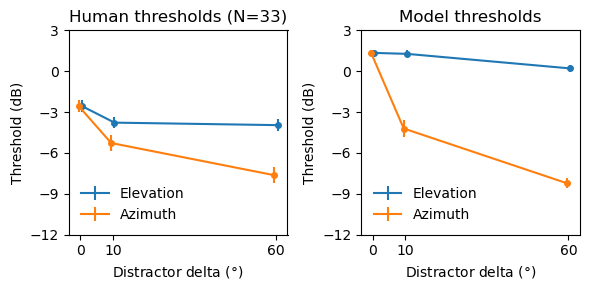

In [6]:
#### Per sex 
fig, axs = plt.subplots(1,2,figsize=(6,3))


for ix, ax in enumerate(axs):
    if ix == 0:
        elev_data = human_thresh_df_summary[human_thresh_df_summary.azim_delta == 0]
        azim_data = human_thresh_df_summary[human_thresh_df_summary.elev_delta == 0]
    elif ix == 1: 
        elev_data = model_thresh_df[(model_thresh_df.azim_delta == 0)] #& (model_thresh_df.model.str.contains('v10'))]
        azim_data = model_thresh_df[(model_thresh_df.elev_delta == 0)]# & (model_thresh_df.model.str.contains('v10'))]
    elev_to_plot = elev_data
    azim_to_plot = azim_data
  
    ax.errorbar(data=elev_to_plot, x=elev_to_plot.elev_delta + 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Elevation', markersize=4)
    ax.errorbar(data=azim_to_plot, x=azim_to_plot.azim_delta - 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Azimuth',markersize=4)

    ax.legend(loc='lower left', markerscale=0)
    ax.get_legend().get_frame().set_linewidth(0.0)

    ax.set_xlabel('Distractor delta ($\degree$)')
    ax.set_ylabel('Threshold (dB)')
    ax.set_xticks([0, 10, 60])
    ax.set_yticks(np.arange(-12, 4, 3))
    if ix == 0:
        ax.set_title(f"Human thresholds (N={N})" )
    elif ix == 1:
        ax.set_title("Model thresholds" )

plt.tight_layout()
# plt.savefig(fig_out_dir / "figure_4c.pdf", transparent=True, bbox_inches='tight')

# Plot practice effect using raw humna data (Figure 4f left)

In [9]:

raw_human_data = pd.read_pickle(path_to_human_results / 'raw_participant_threshold_data.pdpkl')
raw_model_data = pd.read_csv('final_results_to_share/experiment_6_fba_model_summary.csv')

In [10]:
### 80 trials per block. First block is trial num < 80. Last block is trial num <= 400. 
practice_effect_df = raw_human_data.copy()
# digitize trial number into 6 bins 
block_cutoffs = np.arange(0, 480, 80)
practice_effect_df['exp_block'] = np.digitize(practice_effect_df.trial_num, block_cutoffs, right=False)
# practice_effect_df = practice_effect_df[practice_effect_df.exp_block.isin([1,6])]
practice_effect_df = practice_effect_df.groupby(['participant', 'exp_block']).correct.mean().reset_index()
# sns.lineplot(data=practice_effect_df, x='exp_block', y='correct', errorbar=('se', 1))

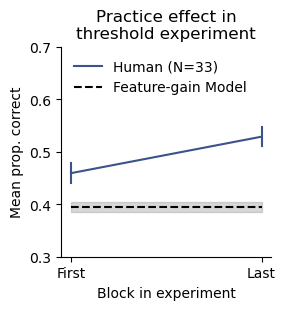

In [12]:
### Simplify practice effect plot
model_acc_mean, model_acc_sem = raw_model_data.groupby('model').accuracy.mean().reset_index().agg({'accuracy':['mean', 'sem']}).values

block_ixs = [1,6] # first and last 
to_plot = practice_effect_df[practice_effect_df.exp_block.isin(block_ixs)]

human_color = sns.color_palette("viridis", as_cmap=True)(0.25)

g = sns.relplot(data=to_plot, x='exp_block', y='correct',
            # hue='azim_delta', # hue_order=hue_order,
            errorbar=('se', 1),err_style='bars',
            height=3,
            color=human_color,
            kind='line', aspect=1)
g.set(xticks=block_ixs, xticklabels=['First', 'Last'], )
# add error bar for model mean accuracy
ax = g.axes[0,0]
ax.plot(block_ixs, [model_acc_mean, model_acc_mean], '--k')
ax.set_ylim(0.3, .7)

## Add legend manually 

legend_handles = [
    Line2D([0], [0], marker='', color=human_color,
           label=f"Human (N={N})",
           markerfacecolor=human_color,
           )
           ,   
        Line2D([0], [0], ls='--', color='k',
           label=f"Feature-gain Model",
           markerfacecolor='k',
           )
            ]

fontsize=10

color_legend = ax.legend(handles=legend_handles, title="", frameon=False,
                              loc='upper left', fontsize=fontsize, title_fontsize=fontsize,
                              bbox_to_anchor=(0, 1),
                            #   bbox_transform=fig.transFigure
                              ) 
ax.fill_between(block_ixs, model_acc_mean + model_acc_sem,  model_acc_mean - model_acc_sem, alpha=0.3, color='grey')
# g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
g.set_axis_labels("Block in experiment", "Mean prop. correct")
# g.legend.set_title("Azimuth\noffset\n(degrees)")
ax.set_title('Practice effect in\nthreshold experiment', fontsize=12,)

## Make panel aspect square 
ratio = 1.0 
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
# g.savefig(fig_out_dir / "figure_4_threshold_practice_effect.pdf", transparent=True, bbox_inches='tight')